# Capsule (Tutorial)
Built on top of `nn.Module` for faster prototyping

In [1]:
# | default_exp trainer.capsule

In [2]:
# | export
from functools import wraps
from torch_snippets.loader import *
from torch_snippets.torch_loader import *
from torch_snippets.paths import loaddill, dumpdill, makedir, parent
from torch_snippets.load_defaults import exists
from torch_snippets.markup import AttrDict

try:
    import mmcv
    from mmcv.parallel.data_container import DataContainer
except ImportError:
    DataContainer = None

/Users/yeshwanth.y/miniconda3/envs/mdm/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/yeshwanth.y/miniconda3/envs/mdm/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c106detail19maybe_wrap_dim_slowExxb)
  Referenced from: '/Users/yeshwanth.y/miniconda3/envs/mdm/lib/python3.8/site-packages/torchvision/image.so'
  Expected in: '/Users/yeshwanth.y/miniconda3/envs/mdm/lib/python3.8/site-packages/torch/lib/libc10.dylib'
  warn(f"Failed to load image Python extension: {e}")


In [4]:
# | export
# | hide


def to(item, device):
    if item is None:
        return None
    elif isinstance(item, (torch.Tensor, nn.Module)):
        return item.to(device)
    elif isinstance(item, (AttrDict, dict)) or all(
        [hasattr(item, "keys"), hasattr(item, "values"), hasattr(item, "items")]
    ):
        return type(item)({k: to(v, device) for k, v in item.items()})
    elif isinstance(item, (list, tuple)):
        return type(item([to(_item, device) for _item in item]))
    elif DataContainer is not None and isinstance(item, DataContainer):
        return DataContainer([to(_item, device) for _item in item.data])
    else:
        # logger.warning(f"function is not implemented for {type(item)}")
        return item
        raise NotImplementedError(f"function is not implemented for {type(item)}")


def train(train_function):
    @wraps(train_function)
    def _train_batch(self, *args, **kwargs):
        args = self.before_train_batch(args)
        kwargs = self.before_train_batch(kwargs)
        outputs = train_function(self, *args, **kwargs)
        outputs = self.after_train_batch(outputs)
        assert isinstance(outputs, dict)
        return outputs

    return _train_batch


@torch.no_grad()
def validate(validation_function):
    @wraps(validation_function)
    def _validate_batch(self, *args, **kwargs):
        args = self.before_validate_batch(args)
        kwargs = self.before_validate_batch(kwargs)
        outputs = validation_function(self, *args, **kwargs)
        outputs = self.after_validate_batch(outputs)
        assert isinstance(outputs, dict)
        return outputs

    return _validate_batch


@torch.no_grad()
def predict(predict_function):
    @wraps(predict_function)
    def _predict(self, *args, **kwargs):
        args = self.before_predict(args)
        kwargs = self.before_predict(kwargs)
        outputs = predict_function(self, *args, **kwargs)
        return outputs

    return _predict

In [4]:
# | export
# | hide


class Capsule(nn.Module):
    """
    Inherit from Capsule and train with fewer lines of code
    """

    def __init__(self, report=None):
        super().__init__()
        if report is not None:
            self.report = loaddill(report)

    # Train Utils
    def before_train_batch(self, data):
        self.train()
        self.optimizer.zero_grad()
        data = to(data, getattr(self, "device", "cuda"))
        return data

    def after_train_batch(self, outputs):
        outputs["loss"].backward()
        self.optimizer.step()
        return outputs

    # Validation Utils
    def before_validate_batch(self, data):
        self.eval()
        data = to(data, getattr(self, "device", "cuda"))
        return data

    def after_validate_batch(self, outputs):
        return outputs

    def before_predict(self, data):
        self.eval()
        data = to(data, getattr(self, "device", "cuda"))
        return data

    def after_predict(self, outputs):
        return outputs

    def load(self, weights_path=None, device="cpu"):
        if weights_path:
            load_torch_model_weights_to(self, weights_path, device=device)
        try:
            weights_path = weights_path + ".report"
            self.report = loaddill(weights_path)
        except:
            pass

    def save(self, save_to):
        if not exists(parent(save_to)):
            makedir(parent(save_to), prompt=False)
        save_torch_model_weights_from(self, save_to)
        if hasattr(self, "report"):
            save_to = save_to + ".report"
            dumpdill(self.report, save_to)

    # Fit function
    def fit(
        self,
        trn_dl=None,
        val_dl=None,
        num_epochs=1,
        lr=None,
        device="cuda",
        save_to=None,
        print_every=None,
        print_total=None,
        show_final_plot=True,
        **kwargs,
    ):
        if print_total:
            print_every = num_epochs // print_total

        if lr:
            for group in self.optimizer.param_groups:
                group["lr"] = lr
            Info(f"Learning Rate: {lr}")

        if not hasattr(self, "report"):
            self.report = Report(num_epochs, **kwargs)
        else:
            self.report = Report(num_epochs, old_report=self.report, **kwargs)

        self.device = device
        to(self, self.device)

        try:
            for epoch in range(num_epochs):
                self.report.n_epochs = num_epochs
                if trn_dl is not None:
                    N = len(trn_dl)
                    for ix, data in enumerate(trn_dl):
                        loss = self.train_batch(data)
                        self.report.record(pos=(epoch + (ix + 1) / N), **loss, end="\r")
                if val_dl is not None:
                    self.evaluate(
                        val_dl, report=self.report, device=device, epoch=epoch
                    )
                if (print_every and ((epoch + 1) % print_every == 0)) or epoch == 0:
                    self.report.report_avgs(epoch + 1)
                else:
                    self.report.report_avgs(epoch + 1, end="\r")
        except KeyboardInterrupt:
            pass

        if show_final_plot:
            self.report.plot(log=True, smooth=0)
        if save_to:
            self.save(save_to)
        self.report.finish_run(**kwargs)

    def evaluate(
        self, val_dl, report=None, device="cuda", epoch=None, show_report=False
    ):
        if report is None:
            report = Report(1)
            epoch = 0
            report_averages = True
        else:
            epoch = epoch
            report_averages = False
        self.device = device
        to(self, self.device)

        N = len(val_dl)
        for ix, data in enumerate(val_dl):
            loss = self.validate_batch(data)
            report.record(pos=(epoch + (ix + 1) / N), **loss, end="\r")

        avgs = report.report_avgs(1) if report_averages else None
        if show_report:
            report.plot(log=True, smooth=3)
        return avgs

    @train
    def train_batch(self, data):
        x, y = data
        _y = self(x)
        loss = self.criterion(_y, y)
        return {"loss": loss}

    @validate
    def validate_batch(self, data):
        x, y = data
        output = self(x)
        loss = self.criterion(output, y)
        return {"loss": loss}

    @predict
    def predict_batch(self, data):
        x, _ = data
        outputs = self(x)
        return outputs

Let's load the iris dataset first

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X, y = data.data, data.target
X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=42)

... and create the data loaders

In [6]:
from torch_snippets.inspector import inspect
from torch.utils.data import TensorDataset

trn_ds = TensorDataset(*[torch.Tensor(i) for i in [X_trn, y_trn]])
trn_dl = DataLoader(trn_ds, batch_size=32)

val_ds = TensorDataset(*[torch.Tensor(i) for i in [X_val, y_val]])
val_dl = DataLoader(val_ds, batch_size=32)

inspect(next(iter(val_dl)))

══════════════════════════════════════════════════════════════════
list of 2 items
        Tensor  Shape: torch.Size([32, 4])      Min: 0.100      Max: 7.900      
Mean: 3.488     dtype: torch.float32 @ cpu
        Tensor  Shape: torch.Size([32]) Min: 0.000      Max: 2.000      Mean: 
0.969     dtype: torch.float32 @ cpu
══════════════════════════════════════════════════════════════════


Next we'll import Capsule and a few decorators that will tell the model to change it's mode to train/test during the `fit` function

```python
from torch_snippets.trainer.capsule import Capsule, train, validate, predict
```

Create the neural network and define it's forward function as usual pytorch business. Only difference now is that you'll also add `self.loss_fn` and `self.optimizer` attributes in the init

```python
class IrisModel(Capsule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(4),
            nn.Linear(4, 16),
            nn.Dropout(0.2),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 8),
            nn.Dropout(0.2),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 3),
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())

    def forward(self, x):
        return self.model(x)
```

To fully describe the model's behaviour we still need to define three functions  
1. `train_batch`  
2. `validate_batch` and,  
3. `predict` which is optional  

like so

```python

    @train
    def train_batch(self, batch):
        x, y = batch
        _y = self.forward(x)
        loss = self.loss_fn(_y, y.long())
        return {"loss": loss}

    @validate
    def validate_batch(self, batch=None, dl=None):
        if dl is not None:
            output = []
            for batch in dl:
                output.extend(self.predict(batch=batch)["val_acc"])
            return np.mean(output)
        x, y = batch
        _y = self.forward(x)
        loss = self.loss_fn(_y, y.long())
        acc = (y == _y.max(-1)[1]).float().mean()
        return {"val_loss": loss, "val_acc": acc}

    @predict
    def predict(self, batch=None, dl=None):
        if dl is not None:
            output = []
            for batch in dl:
                output.extend(self.predict(batch=batch))
            return output
        x, y = batch
        _y = self.forward(x)
        o = _y.max(-1)[1].cpu().detach().numpy().tolist()
        return o
```

* Ensure you return dictionaries of losses, accuracy metrics in `train_batch` and `validate_batch` functions. You can return as many metrics during training and validation, they will be auto logged.  
* Also make sure at least one of the keys in `train_batch` is the key **loss**, as this is used to compute gradients.* 

In [7]:
# | hide
from torch_snippets.trainer.capsule import Capsule, train, validate, predict


class IrisModel(Capsule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(4),
            nn.Linear(4, 16),
            nn.Dropout(0.2),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 8),
            nn.Dropout(0.2),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 3),
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())

    def forward(self, x):
        return self.model(x)

    @train
    def train_batch(self, batch):
        x, y = batch
        _y = self.forward(x)
        loss = self.loss_fn(_y, y.long())
        return {"loss": loss}

    @validate
    def validate_batch(self, batch=None, dl=None):
        if dl is not None:
            output = []
            for batch in dl:
                output.extend(self.predict(batch=batch)["val_acc"])
            return np.mean(output)
        x, y = batch
        _y = self.forward(x)
        loss = self.loss_fn(_y, y.long())
        acc = (y == _y.max(-1)[1]).float().mean()
        return {"val_loss": loss, "val_acc": acc}

    @predict
    def predict(self, batch=None, dl=None):
        if dl is not None:
            output = []
            for batch in dl:
                output.extend(self.predict(batch=batch))
            return output
        x, y = batch
        _y = self.forward(x)
        o = _y.max(-1)[1].cpu().detach().numpy().tolist()
        return o

We could now create the model...

In [8]:
model = IrisModel()
model.device = "cpu"

... and run `model.fit` with an optional number of logs to print to the console

EPOCH: 1.000	loss: 1.351	val_loss: 1.403	val_acc: 0.344	(0.69s - 67.83s remaining)
EPOCH: 50.000	loss: 0.608	val_loss: 0.524	val_acc: 1.000	(2.86s - 2.86s remaining)
EPOCH: 100.000	loss: 0.265	val_loss: 0.174	val_acc: 1.000	(3.28s - 0.00s remaining)


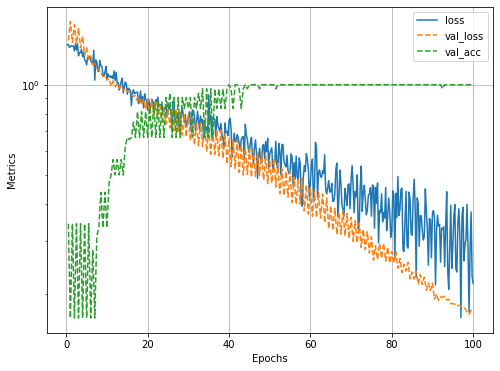

In [9]:
model.fit(trn_dl, val_dl, num_epochs=100, print_total=2, device="cpu")

`model.evaluate` accepts a validation data loader that will repeatedly call `validate_batch` and return aggregated metrics

In [10]:
model.evaluate(val_dl, device="cpu")

EPOCH: 1.000	val_loss: 0.177	val_acc: 1.000	(0.01s - 0.00s remaining)


{'val_loss': 0.1768618, 'val_acc': 1.0}